## Step 1: Importing the required libraries and datasets

In [1821]:
import sys
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from sqlalchemy import text

In [1822]:
# Append root path on execution time that it can find setup.py
sys.path.append(f"{Path(Path.cwd()).parent.absolute()}/")
from setup import setup

db = setup()

In [1823]:
# Get test data from database
result = db.execute(text("select * from RawDB.dbo.D139"))
df = pd.DataFrame(result.fetchall())

Show origin data shape

In [1824]:
df.shape

(147840, 7)

In [1825]:
df.head()

,年月,地區,產業別,性別,教育程度類別,信用卡交易筆數,信用卡交易金額[新台幣]
0,201511,南投縣,百貨,1,高中高職,419,386373
1,201511,南投縣,百貨,1,其他,246,196553
2,201511,南投縣,其他,1,博士,121,560606
3,201511,南投縣,其他,1,碩士,1397,6765858
4,201511,南投縣,其他,1,大學,4596,23640387


## Step 2: Exploratory data analysis and feature engineering
* Clean and pre-processing data
* Split data to training sets (70% - 80%) and test sets
* Feature engineering: categorical values are encoded and other suitable changes are made to the data
* Predictive model is ready

In [1826]:
column_names = df.columns
column_names

Index(['年月', '地區', '產業別', '性別', '教育程度類別', '信用卡交易筆數', '信用卡交易金額[新台幣]'], dtype='object')

In [1827]:
# Value counts of each columns
for col in column_names:
    print(df[col].value_counts())

201511    1344
202108    1344
202207    1344
202206    1344
202205    1344
          ... 
201808    1344
201807    1344
201806    1344
201805    1344
201510    1344
Name: 年月, Length: 110, dtype: int64
南投縣    9240
雲林縣    9240
宜蘭縣    9240
嘉義縣    9240
屏東縣    9240
嘉義市    9240
花蓮縣    9240
台東縣    9240
澎湖縣    9240
金門縣    9240
連江縣    9240
基隆市    9240
新竹市    9240
新竹縣    9240
苗栗縣    9240
彰化縣    9240
Name: 地區, dtype: int64
百貨      21120
其他      21120
食       21120
衣       21120
住       21120
行       21120
文教康樂    21120
Name: 產業別, dtype: int64
1    73920
2    73920
Name: 性別, dtype: int64
高中高職    24640
其他      24640
博士      24640
碩士      24640
大學      24640
專科      24640
Name: 教育程度類別, dtype: int64
0        1776
1         514
3         355
2         350
4         329
         ... 
6609        1
27418       1
18550       1
30565       1
25795       1
Name: 信用卡交易筆數, Length: 26352, dtype: int64
0           1774
2000          38
1600          14
3000          13
1800          12
            ... 
478181 

In [1828]:
# Check if columns have any null value
df.isnull().sum()

年月              0
地區              0
產業別             0
性別              0
教育程度類別          0
信用卡交易筆數         0
信用卡交易金額[新台幣]    0
dtype: int64

In [1829]:
# Choose one target column (or called target attribute, that is, y) and drop from X (features)

# 如果某個分類目標的準確率低，代表這個目標與其他屬性的關聯性低，也就是說，其他屬性不足以準確的分類 (預測) 這個目標
# target = "性別"
# target = "教育程度類別"
# target = "產業別"
target = "信用卡交易金額[新台幣]"
skip_features = ["年月"]
discrete_bin_num = 3
X = df.drop([target] + skip_features, axis=1)
# If value of target column are numeric, divide it into multiple intervals (discretize)
y = df[target] if df[target].dtype == "object" else pd.qcut(df[target], q=discrete_bin_num, labels=False)

Show features X and target y

In [1830]:
X.head()

,地區,產業別,性別,教育程度類別,信用卡交易筆數
0,南投縣,百貨,1,高中高職,419
1,南投縣,百貨,1,其他,246
2,南投縣,其他,1,博士,121
3,南投縣,其他,1,碩士,1397
4,南投縣,其他,1,大學,4596


In [1831]:
y.head()

0    0
1    0
2    0
3    1
4    2
Name: 信用卡交易金額[新台幣], dtype: int64

In [1832]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [1833]:
X_train.shape, X_test.shape

((99052, 5), (48788, 5))

In [1834]:
X.dtypes

地區         object
產業別        object
性別          int64
教育程度類別     object
信用卡交易筆數     int64
dtype: object

In [1835]:
# Prepare category list for encoding
category_frame = X.select_dtypes(include=["object"])

In [1836]:
category_frame.head()

,地區,產業別,教育程度類別
0,南投縣,百貨,高中高職
1,南投縣,百貨,其他
2,南投縣,其他,博士
3,南投縣,其他,碩士
4,南投縣,其他,大學


In [1837]:
# Transform category attribute into encoded value
import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=category_frame.columns)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

In [1838]:
X_train.head()

,地區,產業別,性別,教育程度類別,信用卡交易筆數
129818,1,1,2,1,123
11453,2,2,1,2,15250
142663,3,2,1,3,24631
138042,4,2,1,4,13841
139111,5,3,1,3,1983



## Step 3: Fitting the model, evaluating the results and visualizing the trees
* Data totally prepared
* Classifier is instantiated
* Model is fit onto the data
* Ensure the model is neither over fitting and under fitting the data
* Evaluate classifier: confusion matrix, precision score, f1 score, recall, support scores

In [1839]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [1840]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=0)
decision_tree = clf.fit(X_train, y_train)

In [1841]:
y_predict_test = clf.predict(X_test)
y_predict_test

array([0, 2, 0, ..., 0, 0, 1], dtype=int64)

In [1842]:
y_predict_train = clf.predict(X_train)
y_predict_train

array([0, 2, 2, ..., 2, 0, 0], dtype=int64)

In [1843]:
print("Training set score: {:.4f}".format(accuracy_score(y_train, y_predict_train)))
print("Test set score: {0:0.4f}".format(accuracy_score(y_test, y_predict_test)))

Training set score: 0.7819
Test set score: 0.7489


[Text(0.5, 0.875, 'x[4] <= 1729.5\nentropy = 1.585\nsamples = 99052\nvalue = [33092, 33095, 32865]'),
 Text(0.25, 0.625, 'x[4] <= 419.5\nentropy = 0.874\nsamples = 44927\nvalue = [32561, 12226, 140]'),
 Text(0.125, 0.375, 'x[4] <= 292.5\nentropy = 0.114\nsamples = 24278\nvalue = [23906, 372, 0]'),
 Text(0.0625, 0.125, 'entropy = 0.034\nsamples = 20799\nvalue = [20726, 73, 0]'),
 Text(0.1875, 0.125, 'entropy = 0.423\nsamples = 3479\nvalue = [3180, 299, 0]'),
 Text(0.375, 0.375, 'x[1] <= 2.5\nentropy = 1.034\nsamples = 20649\nvalue = [8655, 11854, 140]'),
 Text(0.3125, 0.125, 'entropy = 0.746\nsamples = 4995\nvalue = [3933, 1062, 0]'),
 Text(0.4375, 0.125, 'entropy = 0.952\nsamples = 15654\nvalue = [4722, 10792, 140]'),
 Text(0.75, 0.625, 'x[4] <= 12821.0\nentropy = 1.034\nsamples = 54125\nvalue = [531, 20869, 32725]'),
 Text(0.625, 0.375, 'x[4] <= 2930.5\nentropy = 1.086\nsamples = 41338\nvalue = [531, 20674, 20133]'),
 Text(0.5625, 0.125, 'entropy = 0.998\nsamples = 11712\nvalue = [507

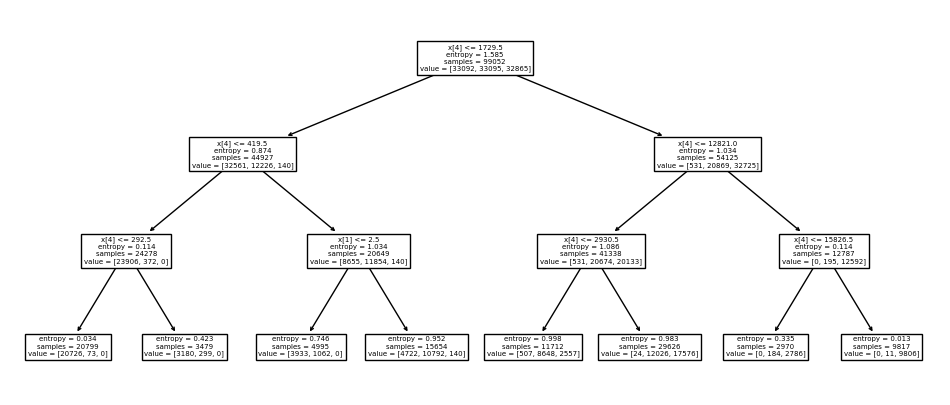

In [1844]:
plt.figure(figsize=(12, 8))
from sklearn import tree

tree.plot_tree(decision_tree)